In [3]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    
    # AC-like 3, MN33 very noisy for NN analysis
    #'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'
    
    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',
    'MES-like 8': '#C50F53',
    'MES-like 6': '#840034',

    
    'NPC-like 1':'#FFF192',
    'NPC-like 2':'#FFF192',
    'NPC-like 3':'#FFF192',
    
    'RG 1':'#ff9470',
    'RG 2':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    'OPC-like 3':'#89c4f4', #bright turquoise
    
    'Endothelial':'#d5b8ff', #mauve
    'Endothelial 1':'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell 2': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    
    'Fibroblast': '#fbe7ef',
    'FB-like 1': '#FF6EC7', #fff9de
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
    
    'Mono 1': '#FBFCFA',#'#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-BDM 1':'#e88474',#'#F5C9B0',
    'TAM-BDM 2':'#A94A54',
    
    'TAM-BDM 3':'#DC9D57',    #'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    'DC': '#a6915c',

}


cluster_annotation = {
    'TAM-MG 1': 'Mono 1',
    'TAM-BDM 1': 'Mono 1',
    'Mono 2': 'Mono 1',
    
    'DC 1': 'DC',
    
    'Mono 3': 'Mono 1',
    'TAM-BDM 6': 'Mono 1',
    'TAM-MG 2': 'TAM-MG',
    
    'Mono 4':'Mono 2',
    
    'Plasma B 2': 'TAM-BDM 1',
    'TAM-BDM 2': 'TAM-BDM 2',
    'TAM-BDM 3':'TAM-BDM 3',
    'TAM-BDM 4': 'TAM-BDM 4',
    
}

In [5]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    
    # AC-like 3, MN33 very noisy for NN analysis
    #'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'
    
    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',
    'MES-like 8': '#C50F53',
    'MES-like 6': '#840034',

    
    'NPC-like 1':'#FFF192',
    'NPC-like 2':'#FFF192',
    'NPC-like 3':'#FFF192',
    
    'RG 1':'#ff9470',
    'RG 2':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    'OPC-like 3':'#89c4f4', #bright turquoise
    
    'Endothelial':'#d5b8ff', #mauve
    'Endothelial 1':'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell 2': '#8c14fc',  #electric indigo
    'Mural': '#8c14fc',  #electric indigo
    
    'Fibroblast': '#fbe7ef',
    'FB-like 1': '#FF6EC7', #fff9de
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
    
    'Mono 1': '#FBFCFA',#'#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#FBFCFA',
    
    'TAM-BDM 1':'#e88474',#'#F5C9B0',
    'TAM-BDM 2':'#A94A54',
    
    'TAM-BDM 3':'#DC9D57',    #'#89c4f4',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#DC9D57',#'#A5765C',
    
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    'DC': '#a6915c',

}
new_palette = {
    'RG 2',
    'Endothelial 1', 
    'FB-like 3', 
    'MES-like 6', 
    'MES-like 8', 
    'AC-like 4',
    'AC-like 5', 
    'MES-like 3'
}

In [ ]:
adata = sc.read_h5ad('../EEL_AnnData/EEL_41CleanNuclei-CellularNgh_FeaturesMN.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [ ]:
adata

In [ ]:
sadata= adata[adata.obs.Sample == 'SL016A']

In [ ]:
dic = {}
for cn, mn in zip(sadata.obs.CombinedNameMerge, sadata.obs.MolecularNgh ):
    if cn not in dic:
        dic[cn] = [mn]
    elif mn not in dic[cn]:
        dic[cn].append(mn)
print(dic)

In [10]:
gliosarcoma_palette = {
    'RG 1': '#93faa5',
    'RG 2': '#93faa5',
    'RG 3': '#93faa5',
    
    
    'FB-like 3': '#89c4f4',#'#FF6EC7',
    'FB-like 1': '#89c4f4',#'#FF6EC7',
        

    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',

    'MES-like 8': '#C50F53',
    'MES-like 6': '#d2527f',

    'Endothelial 1': '#8c14fc',
    
    'AC-like 1':'#f2784b', #'#ffffcc',
    'AC-like 2':'#f2784b', #'#ffffcc',
    'AC-like 4':'#f2784b', #'#ffffcc',
    'AC-like 5':'#f2784b', #'#ffffcc',
    'AC-like 6':'#f2784b', #'#ffffcc',
}

new_gs_palette = {

    'RG 1': '#93faa5',
    'RG 2': '#93faa5',
    'RG 3': '#93faa5',
    
    
    'FB-like 3': '#89c4f4',#'#FF6EC7',
    'FB-like 1': '#89c4f4',#'#FF6EC7',
        

    'MES-like 2': '#EDE8F3',
    'MES-like 3': '#E2D8EA',
    'MES-like 1': '#D6BEDD',
    'MES-like 5': '#CFA8D1',
    'MES-like 4': '#CA90C5',
    'MES-like 7': '#D873B6',

    'MES-like 8': '#C50F53',
    'MES-like 6': '#d2527f',

    'Endothelial 1': '#8c14fc',
    
    'AC-like 1':'#f2784b', #'#ffffcc',
    'AC-like 2':'#f2784b', #'#ffffcc',
    'AC-like 4':'#f2784b', #'#ffffcc',
    'AC-like 5':'#f2784b', #'#ffffcc',
    'AC-like 6':'#f2784b', #'#ffffcc',
    
}

2023-06-28 16:44:57,621 - INFO - First filter, 30988 cells left
2023-06-28 16:44:57,912 - INFO - Zoom filter, 30988 cells left


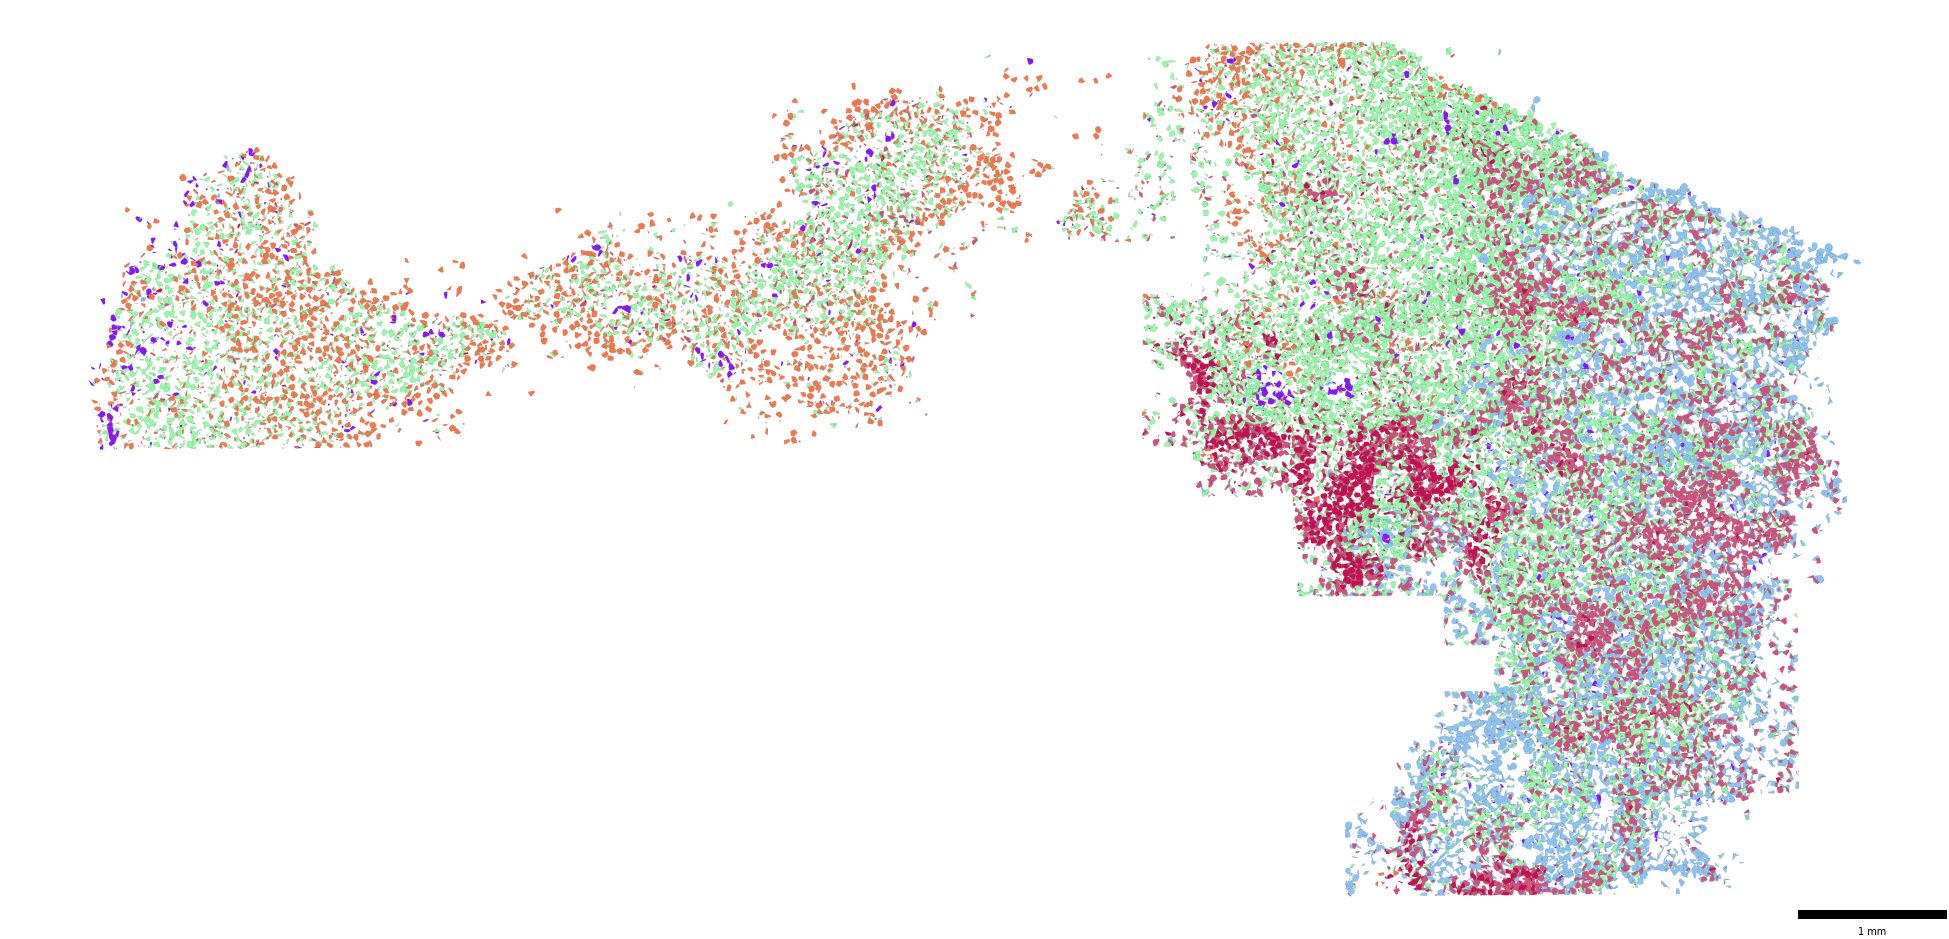

In [138]:
sp.pl.plot_polygons(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    geometry_key='Polygons',
    clusters=['RG 2','Endothelial 1', 'FB-like 3', 'MES-like 6', 'MES-like 8', 'AC-like 4','AC-like 5', 'MES-like 3'],
    markersize=10,
    alpha=1,
    area_min_size=5,
    palette= gliosarcoma_palette,
    save=True,
    figsize=(20,20),
    savepath='figures/SL016A.svg'
    
)

In [ ]:
sp.pl.plot_polygons(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    geometry_key='Polygons',
    clusters=['RG 2','Endothelial 1', 'FB-like 3', 'MES-like 6', 'MES-like 8', 'AC-like 4','AC-like 5'],
    markersize=10,
    alpha=1,
    area_min_size=5,
    palette= gliosarcoma_palette,
    figsize=(20,20),
    show_axis=True

    
)

INFO:root:First filter, 30988 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 1110 cells left


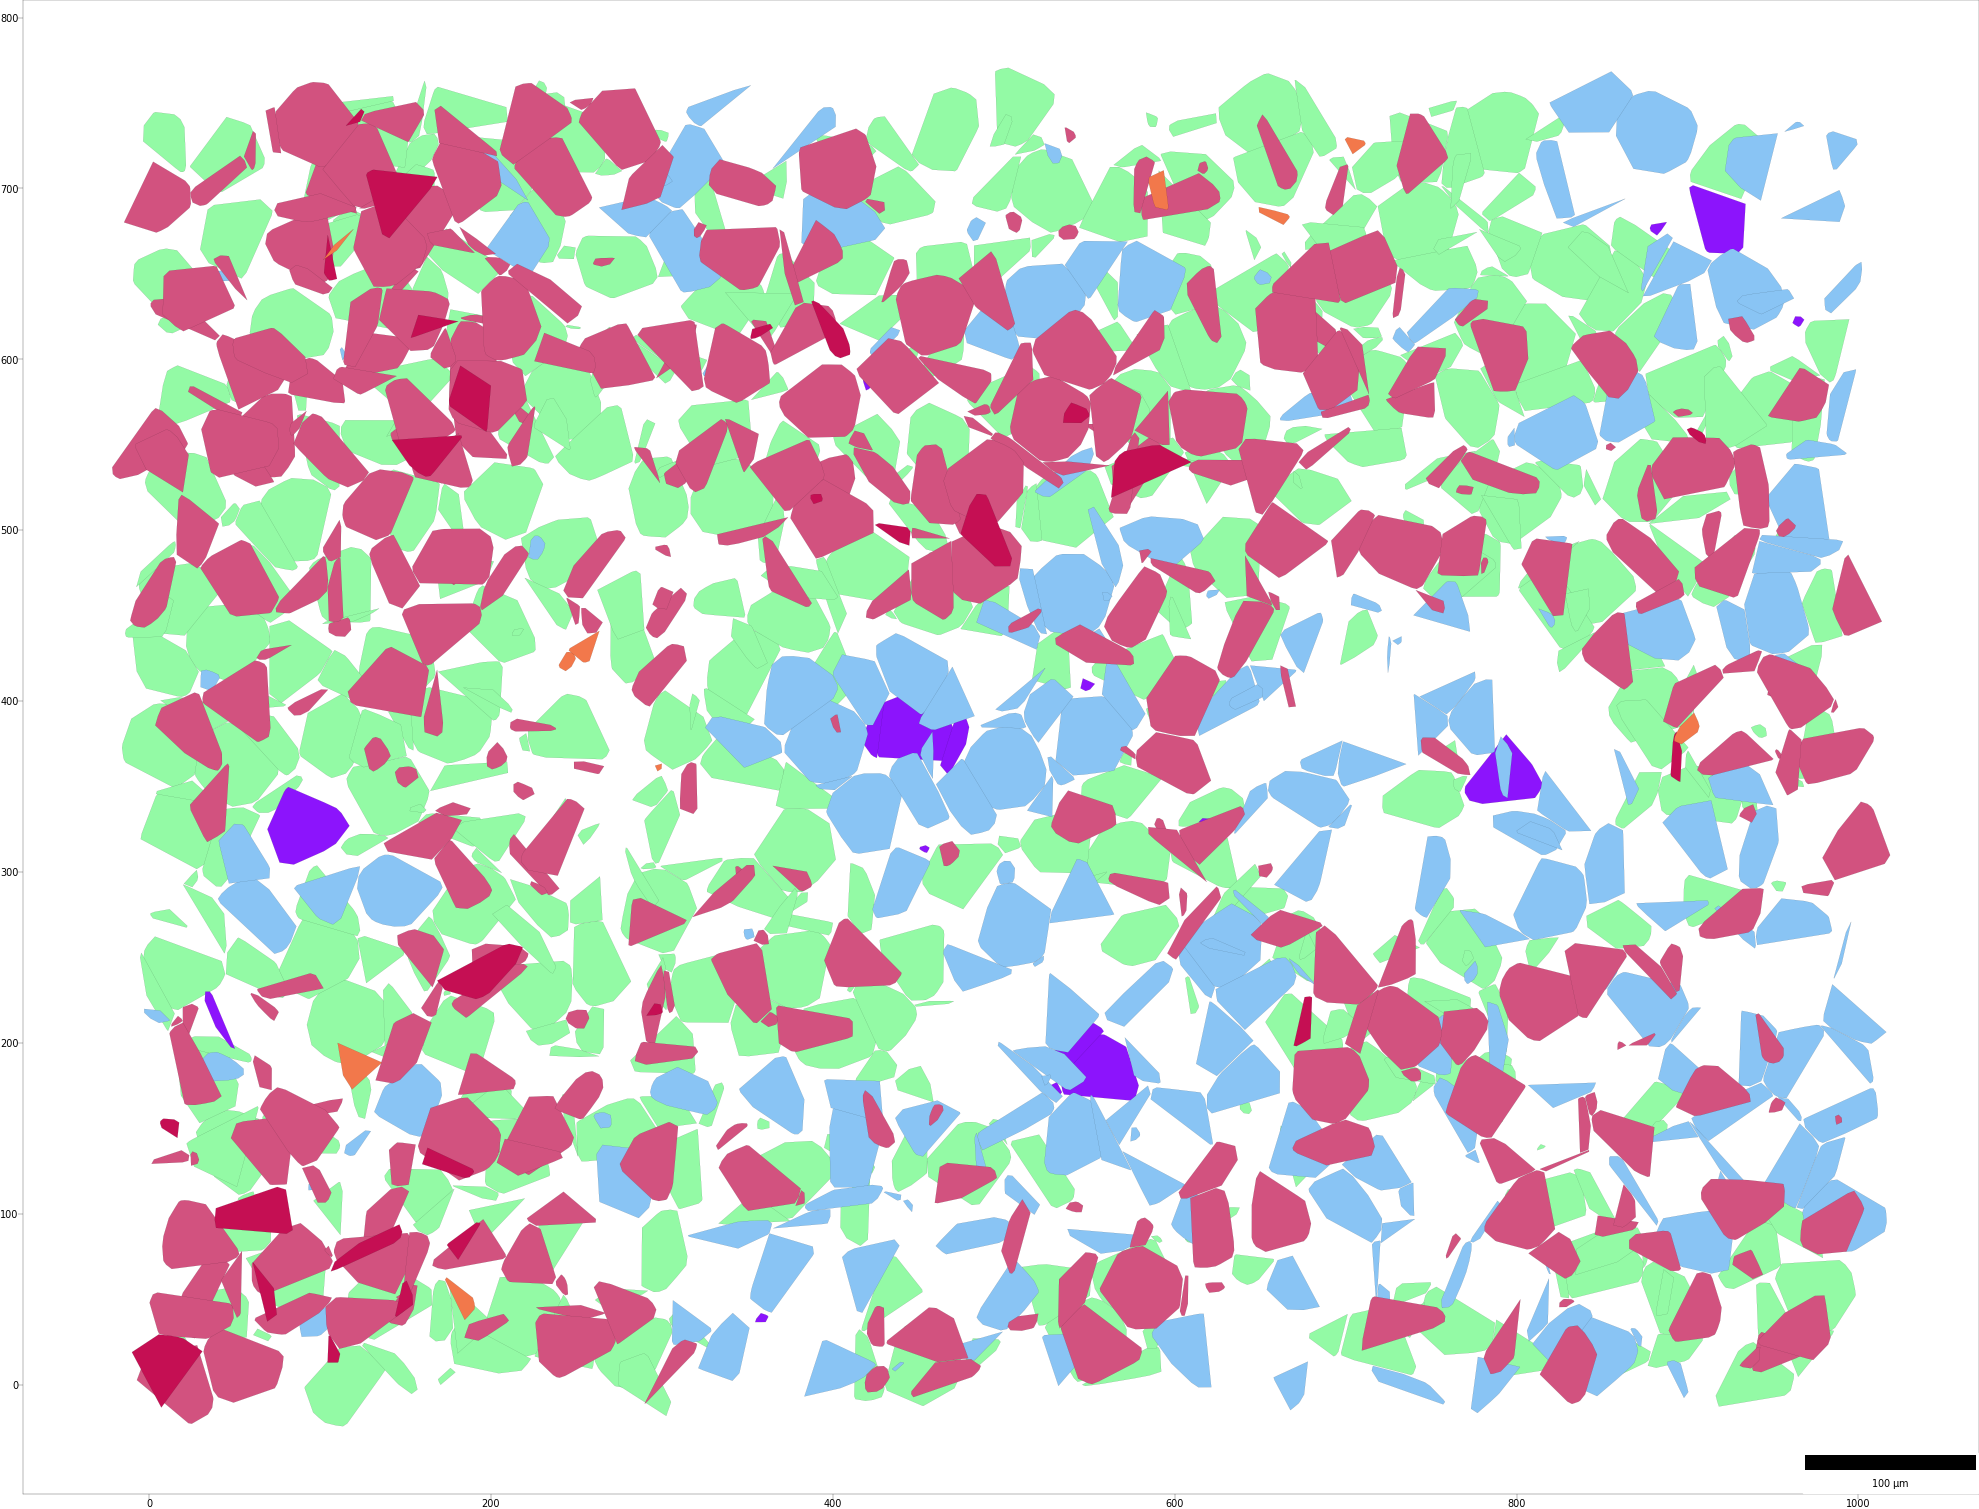

In [92]:
sp.pl.plot_polygons(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    geometry_key='Polygons',
    clusters=['RG 2','Endothelial 1', 'FB-like 3', 'MES-like 6', 'MES-like 8', 'AC-like 4','AC-like 5'],
    xlim = (9500, 10500),
    ylim = (5000, 5750),
    alpha=1,
    area_min_size=5,
    palette= gliosarcoma_palette,
    figsize=(20,20),
    show_axis=True

    
)

In [93]:
from FISHscale.utils.dataset import Dataset

2023-06-27 13:59:25,593 - INFO - First filter, 96981 cells left
2023-06-27 13:59:26,404 - INFO - Zoom filter, 96981 cells left


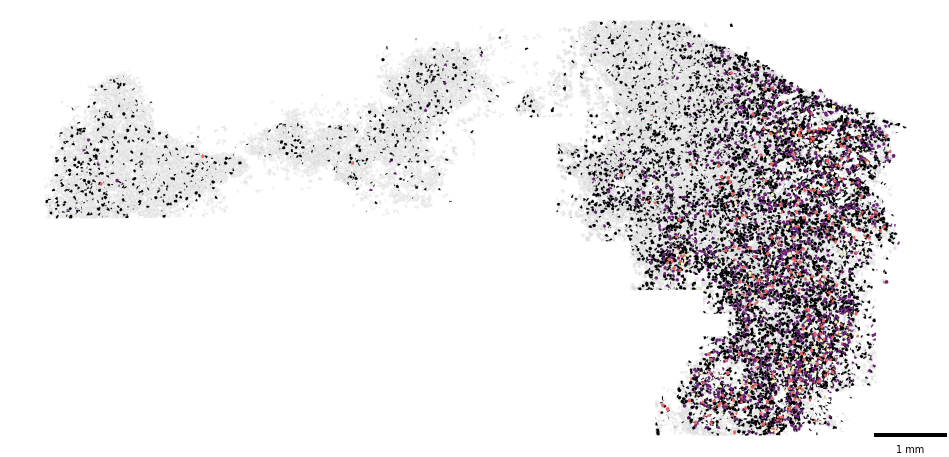

In [ ]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    genes = ['HIF1A'],
    cmap='magma_r',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.999,
    show_axis=False,
    save=True,
    savepath='figures/HIF1A.svg'
)

2023-06-27 14:01:46,768 - INFO - First filter, 96981 cells left
2023-06-27 14:01:47,581 - INFO - Zoom filter, 96981 cells left


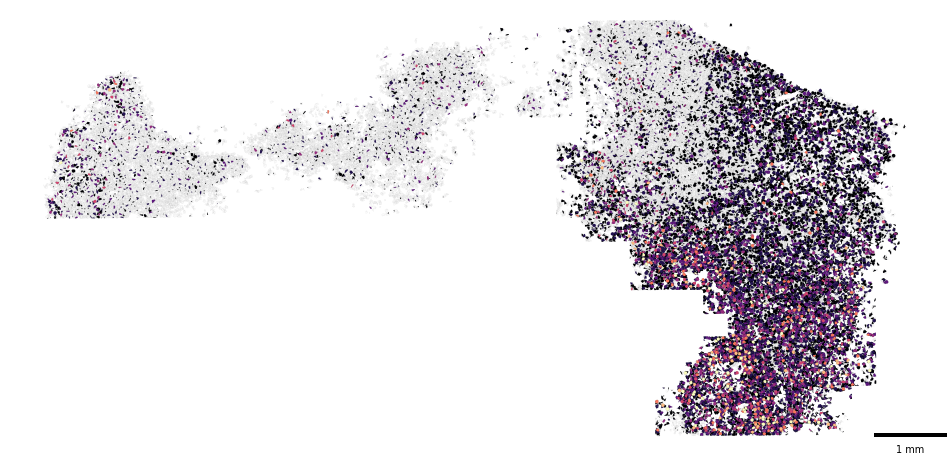

In [125]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    genes = ['TIMP1'],
    cmap='magma',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.999,
    show_axis=False,
    save=True,
    savepath='figures/TIMP1.svg'
)

In [85]:
sadata= adata[adata.obs.Sample == 'SL020']
dic = {}
for cn, mn in zip(sadata.obs.CombinedNameMerge, sadata.obs.MolecularNgh ):
    if cn not in dic:
        dic[cn] = [mn]
    elif mn not in dic[cn]:
        dic[cn].append(mn)
print(dic)

{'unknown 1': [0, 1, 5, 8, 18, 21, 22, 31, 35, 37, 38, 40, 45, 49, 55, 59, 60, 61, 64, 67, 68, 69, 75, 77, 79], 'MES-like 1': [2], 'TAM-BDM 1': [3], 'AC-like 1': [4], 'Endothelial 1': [7], 'unknown2 1': [10, 12, 13, 14, 16, 23, 24, 33, 47, 52, 53, 58, 62, 74], 'RG 1': [11], 'MES-like 5': [15], 'FB-like 3': [17, 20, 29], 'MES-like 6': [19], 'TAM-BDM 2': [25], 'TAM-MG 2': [26], 'Oligodendrocyte 2': [28], 'OPC-like 2': [30], 'FB-like 1': [34, 44], 'AC-like 4': [36, 63, 73], 'AC-like 5': [42, 54], 'preOPC-like 1': [43], 'MES-like 4': [46], 'AC-like 6': [48], 'MES-like 8': [56], 'Plasma B 2': [57], 'AC-like 2': [65], 'TAM-BDM 3': [66], 'Mural cell 1': [70], 'Oligodendrocyte 3': [71], 'TAM-BDM 5': [72], 'MES-like 2': [76]}


In [ ]:
sp.pl.plot_polygons(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    geometry_key='Polygons',
    clusters=['RG 2','Endothelial 1', 'FB-like 3', 'MES-like 6', 'MES-like 8', 'AC-like 4','AC-like 5'],
    markersize=10,
    alpha=1,
    area_min_size=5,
    palette= gliosarcoma_palette,
    figsize=(20,20),
    
)

2023-06-28 16:09:09,368 - INFO - First filter, 41628 cells left
2023-06-28 16:09:09,776 - INFO - Zoom filter, 41628 cells left


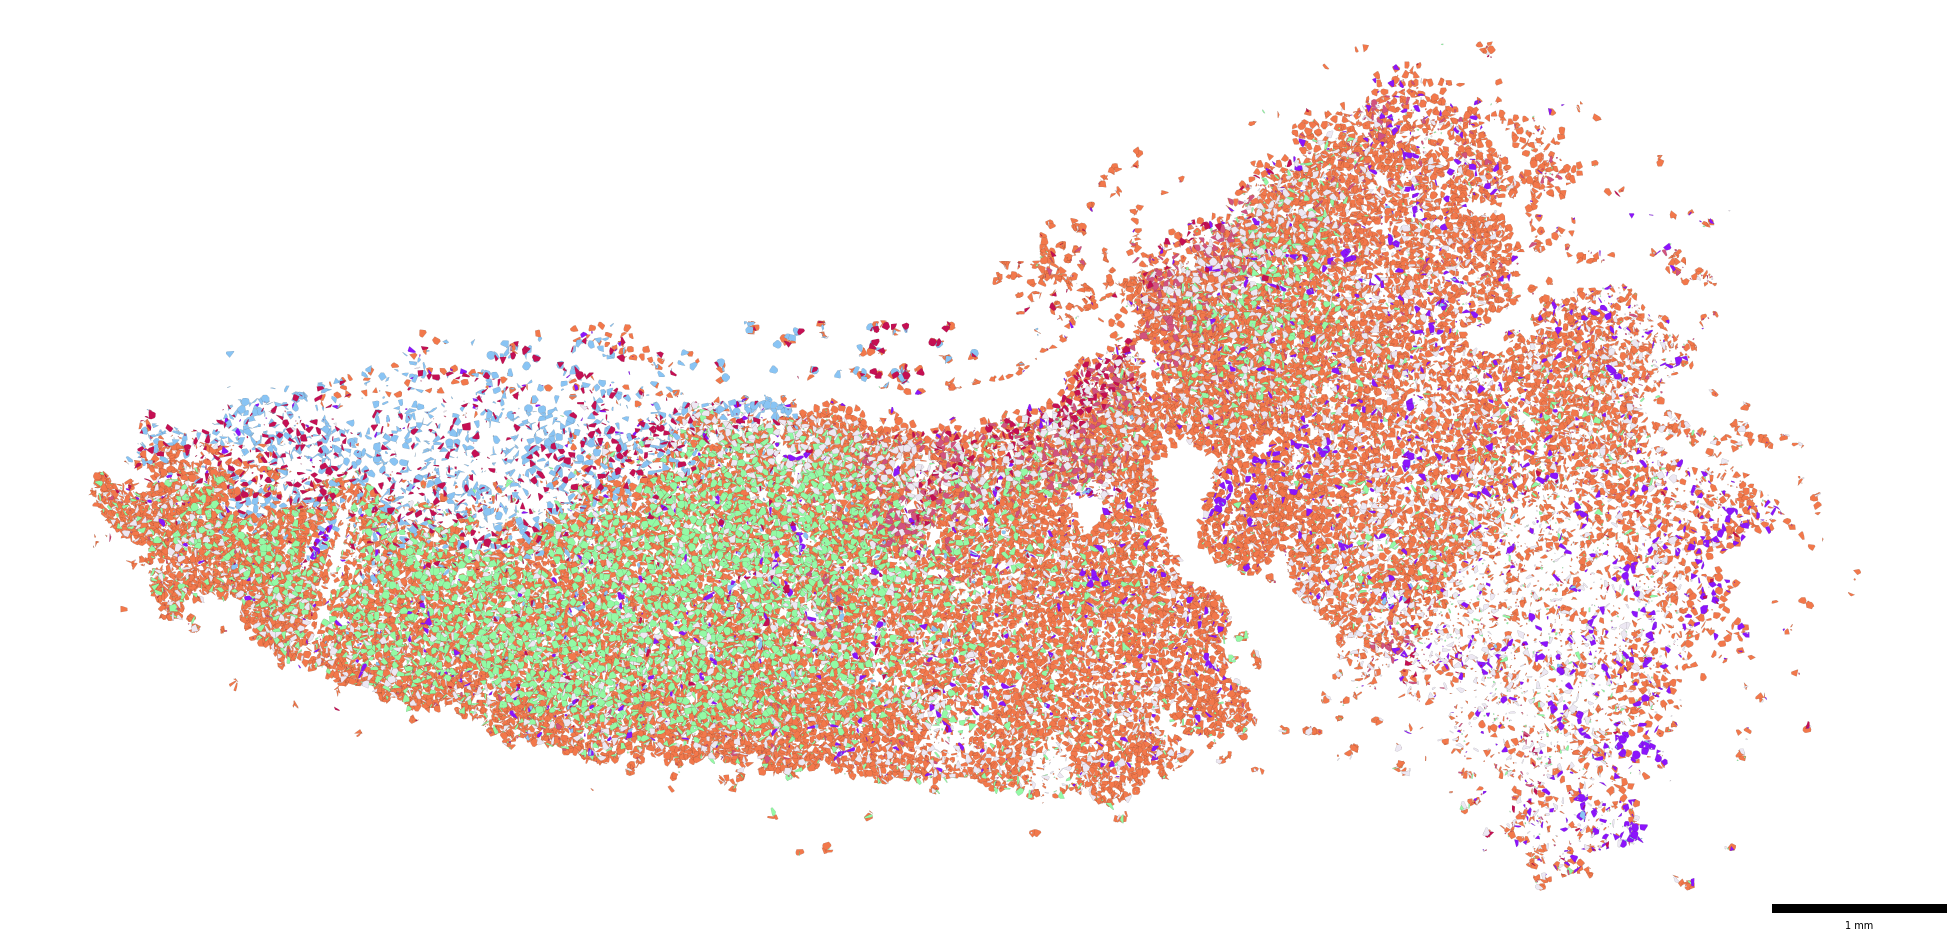

In [137]:
sp.pl.plot_polygons(
    adata,
    sample = 'SL020',
    cluster_key='CombinedNameMerge',
    clusters=[ 'AC-like 4','AC-like 5','RG 1', 'Endothelial 1', 'FB-like 3','MES-like 6','MES-like 8','MES-like 2'],
    area_min_size=5,
    alpha=1,
    palette= gliosarcoma_palette,
    save=True,
    figsize=(20,20),
    savepath='figures/SL020.svg'
    
)

2023-06-27 12:55:26,334 - INFO - First filter, 96981 cells left
2023-06-27 12:55:27,154 - INFO - Zoom filter, 96981 cells left


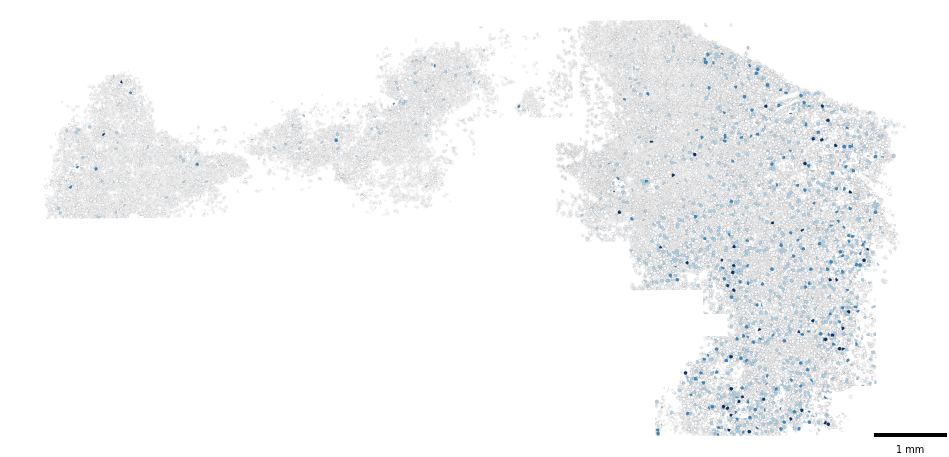

In [116]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    genes = ['TGFB1'],
    cmap='Blues',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.9999,
    show_axis=False,
    #save=True,
    #savepath='figures/TGFBI.svg'
)

2023-06-27 15:55:35,949 - INFO - First filter, 114214 cells left
2023-06-27 15:55:37,511 - INFO - Zoom filter, 114214 cells left


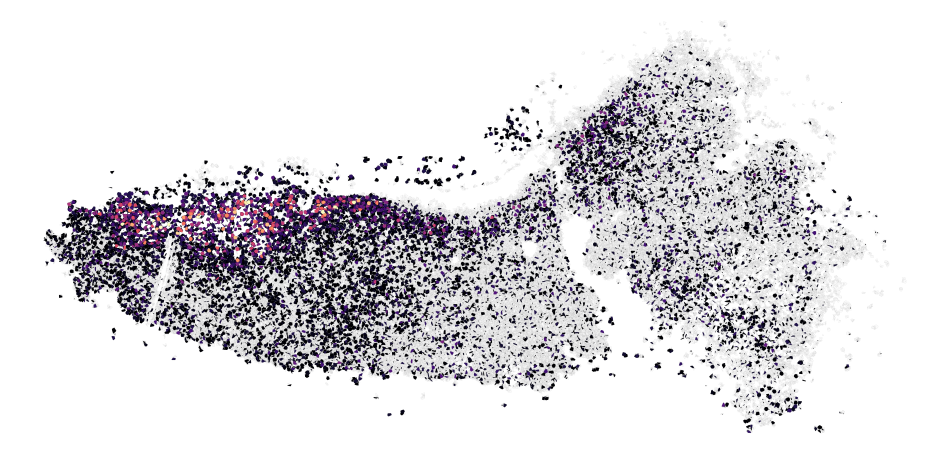

In [130]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL020',
    cluster_key='CombinedNameMerge',
    genes = ['TIMP1'],
    cmap='magma',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.9999,
    show_axis=False,
    save=True,
    show_scalebar=False,
    savepath='figures/SL020_TIMP1.svg'
)

INFO:root:First filter, 96981 cells left
INFO:root:Zoom filter, 96981 cells left


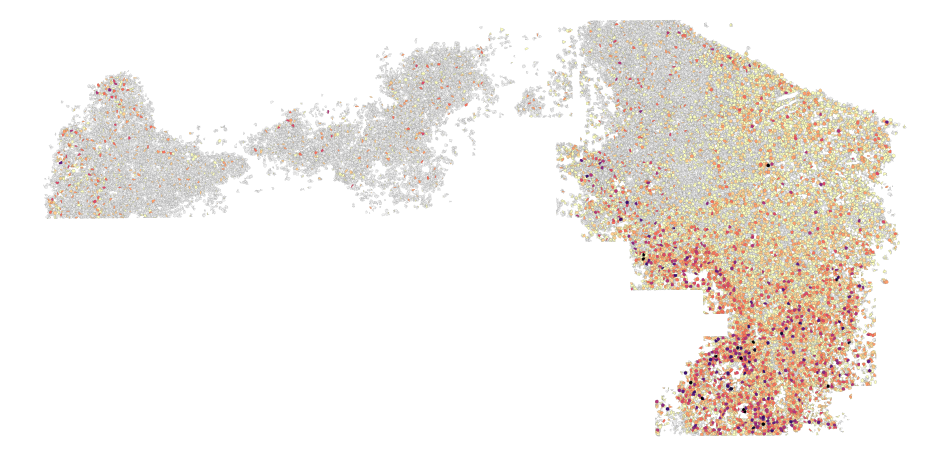

In [11]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    genes = ['TIMP1'],
    cmap='magma_r',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.9999,
    show_scalebar=False,
    show_axis=False,
    save=True,
    savepath='figures/SL016A_TIMP1.svg'
)

INFO:root:First filter, 114214 cells left
INFO:root:Zoom filter, 114214 cells left


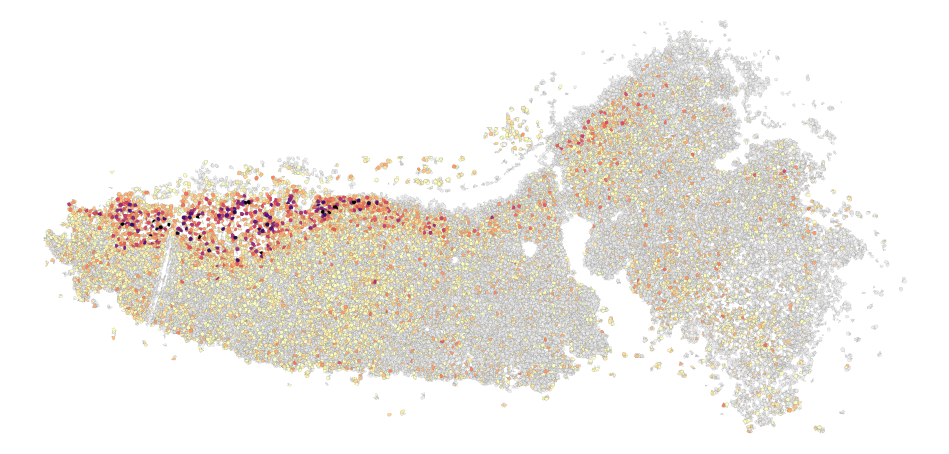

In [12]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL020',
    cluster_key='CombinedNameMerge',
    genes = ['TIMP1'],
    cmap='magma_r',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.9999,
    show_scalebar=False,
    show_axis=False,
    save=True,
    savepath='figures/SL020_TIMP1.svg'
)


2023-06-27 15:40:43,963 - INFO - First filter, 96981 cells left
2023-06-27 15:40:45,392 - INFO - Zoom filter, 96981 cells left


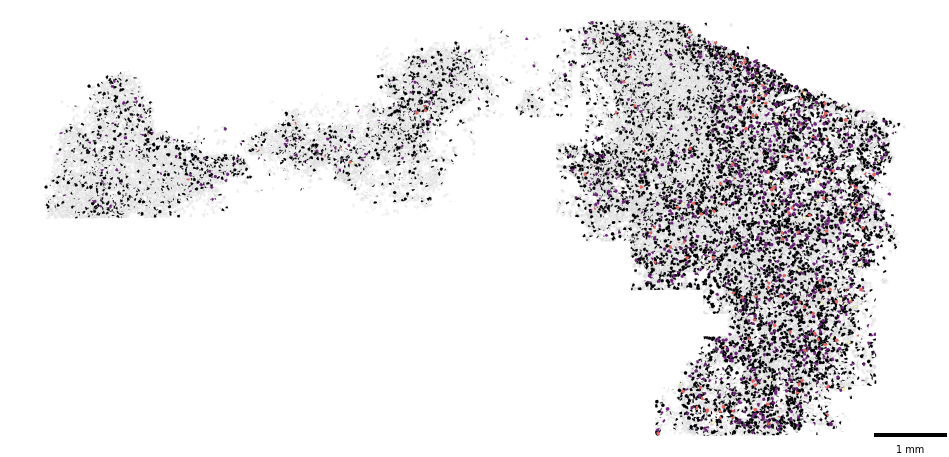

In [128]:
sp.pl.plot_polygons_expression(
    adata,
    sample = 'SL016A',
    cluster_key='CombinedNameMerge',
    genes = ['CDKN1C'],
    cmap='magma',
    alpha=1,
    area_min_size=5,
    figsize=(10,10),
    mquant=0.9999,
    show_axis=False,
    scalebar=False

)